In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [ ]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [4]:
# column headers/feature names
feature_names = ["age", "workclass", "fnlwgt", 
                        "education", "education_num", 
                        "marital_status", "occupation",
                        "relationship", "race", "sex", 
                        "capital_gain", "capital_loss", 
                        "hours_per_week", "native_country", "income"]

In [5]:
train = pd.read_csv(out,header=None,names=feature_names)
target = "income" #' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [6]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,Set
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

age 73
workclass 9
education 16
education_num 16
marital_status 7
occupation 15
relationship 6
race 5
sex 2
capital_gain 119
capital_loss 92
hours_per_week 94
native_country 42
income 2
Set 3


# Define categorical features for categorical embeddings

In [8]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# cat_dims = number of unique values in variable/column
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : A good heuristic is half the number of unique values, up to a maximum of 50. Here our variables have low cardinality. Note that `Set` isn't a feature
cat_emb_dim = [min(v//2+1,50) for v in categorical_dims.values()][:-2] # last 2 variables are target and Set indicator
print("categoricals embeddings dimensions:",cat_emb_dim) 

categoricals embeddings dimensions: [37, 5, 9, 9, 4, 8, 4, 3, 2, 50, 47, 48, 22]


# Network parameters

In [9]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cuda


# Training

In [10]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [12]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs, patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 20 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.68724 |  0.72008 |   5.2       
| 2     | 0.82084 |  0.80851 |   9.0       
| 3     | 0.87181 |  0.83926 |   12.7      
| 4     | 0.88985 |  0.87240 |   16.2      
| 5     | 0.89602 |  0.88669 |   19.8      
| 6     | 0.90584 |  0.89925 |   23.3      
| 7     | 0.90790 |  0.90305 |   26.9      
| 8     | 0.91442 |  0.90646 |   30.6      
| 9     | 0.91674 |  0.90880 |   34.3      
| 10    | 0.91813 |  0.90964 |   37.9      
| 11    | 0.92201 |  0.91584 |   41.5      
| 12    | 0.92682 |  0.91733 |   45.1      
| 13    | 0.92639 |  0.92029 |   48.9      
| 14    | 0.92902 |  0.91958 |   52.7      
| 15    | 0.92799 |  0.91846 |   56.4      
| 16    | 0.93095 |  0.91424 |   60.0      
| 17    | 0.93176 |  0.92001 |   63.6      
| 18    | 0.93145 |  0.91596 |   67.1      
| 19    | 0.92915 |  0.92250 |   70.7      
| 20

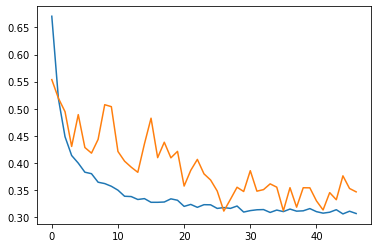

In [13]:
# plot losses
plt.plot(clf.history['train']['loss'])
plt.plot(clf.history['valid']['loss'])

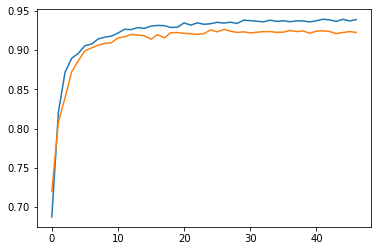

In [14]:
# plot auc
plt.plot([-x for x in clf.history['train']['metric']])
plt.plot([-x for x in clf.history['valid']['metric']])

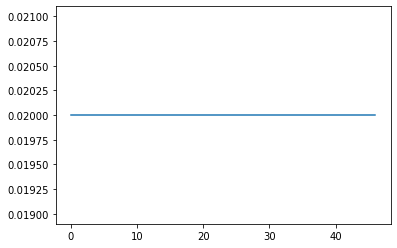

In [15]:
# plot learning rates
plt.plot([x for x in clf.history['train']['lr']])

## Predictions

In [32]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost:.8}")
print(f"FINAL AUC TEST SCORE FOR {dataset_name} : {test_auc:.5}")

BEST VALID SCORE FOR census-income : -0.92661989
FINAL AUC TEST SCORE FOR census-income : 0.92234


# Save and load Model

In [17]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [18]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [19]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.922338917417995


In [20]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [21]:
clf.feature_importances_

array([0.06492022, 0.01551775, 0.01916637, 0.02928418, 0.01400832,
       0.13389507, 0.10640079, 0.03205807, 0.07595738, 0.08574746,
       0.21974053, 0.16876696, 0.02087355, 0.01366334])

In [22]:
important_features = pd.Series(data=clf.feature_importances_,index=train.columns[:-2])
important_features.sort_values(ascending=False,inplace=True)

display(important_features.sort_values(ascending=False))

capital_gain      0.219741
capital_loss      0.168767
marital_status    0.133895
occupation        0.106401
sex               0.085747
race              0.075957
age               0.064920
relationship      0.032058
education         0.029284
hours_per_week    0.020874
fnlwgt            0.019166
workclass         0.015518
education_num     0.014008
native_country    0.013663
dtype: float64

# Local explainability and masks

In [23]:
explain_matrix, masks = clf.explain(X_test)

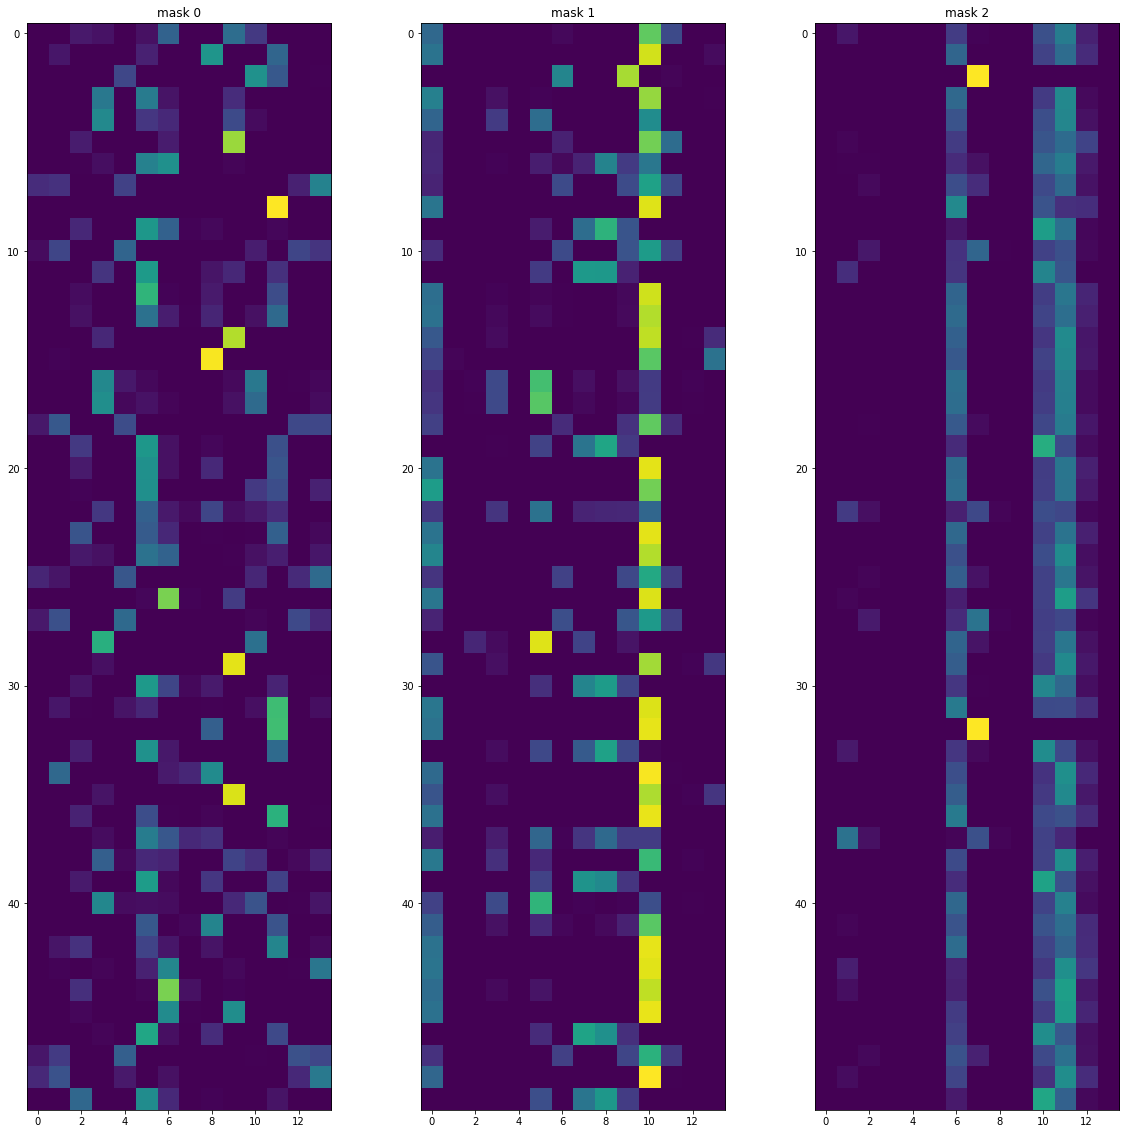

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [25]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=20,
        verbose=10)

[0]	validation_0-error:0.14902
Will train until validation_0-error hasn't improved in 20 rounds.
[10]	validation_0-error:0.14002
[20]	validation_0-error:0.13629
[30]	validation_0-error:0.13008
[40]	validation_0-error:0.12574
[50]	validation_0-error:0.12791
[60]	validation_0-error:0.12574
Stopping. Best iteration:
[44]	validation_0-error:0.12449



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=0)

In [34]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(round(valid_auc,6))

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(round(test_auc,6))

0.924052
0.9196
